In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow import keras
from keras.models import load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.preprocessing import image
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix

**Splitting into train test and val**

In [2]:
import os
os.listdir('.')

['weather-detection.ipynb', 'Weather_Data', '.ipynb_checkpoints']

In [3]:
import splitfolders
splitfolders.ratio("./Weather_Data",output='Trian-test-Val',ratio=(0.8,0.1,0.1))

**Generating data**

In [4]:
train_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  horizontal_flip=True
                 )

val_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  horizontal_flip=True
                 )

test_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input
                 )

In [5]:
train_ds = train_gen.flow_from_directory("./Trian-test-Val/train",
                                       target_size=(150,150),
                                        seed = 123,
                                        batch_size=20
                                       )

val_ds = val_gen.flow_from_directory("./Trian-test-Val/val",
                                       target_size=(150,150),
                                        seed = 123,
                                        batch_size=20)

test_ds = test_gen.flow_from_directory("./Trian-test-Val/test",
                                       target_size=(150,150),
                                        seed = 123,
                                        batch_size=20,
                                      shuffle=False
                                      )

Found 899 images belonging to 4 classes.
Found 111 images belonging to 4 classes.
Found 115 images belonging to 4 classes.


**Getting class names**

In [6]:
names = train_ds.class_indices
classes = list(names.keys())
classes

['Cloudy', 'Dawn', 'Rainy', 'Sunny']

**Visualizing some images**

In [7]:
x,y = next(train_ds)
x.shape

(20, 150, 150, 3)

In [8]:
#plot function
def plot_images(img,labels):
    plt.figure(figsize=(15,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(img[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

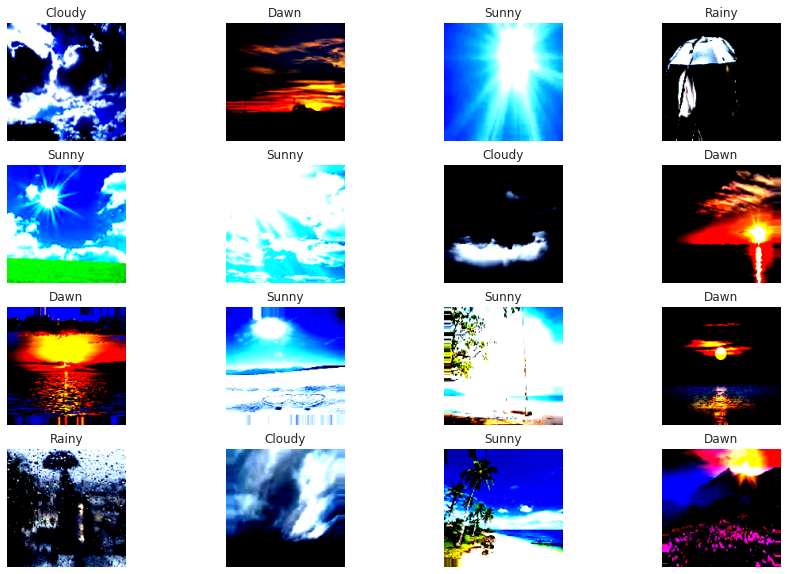

In [9]:
plot_images(x,y)

**MODEL**

In [10]:
from keras.applications.densenet import DenseNet169

In [11]:
base_model = DenseNet169(include_top=False,
                     weights='imagenet',
                     input_shape=(150,150,3)
                     )
base_model.trainable = False

51888128/51877672 [==============================] - 28s 1us/step


In [12]:
model = Sequential([
    base_model,
    
    Flatten(),
    
    Dense(64,activation='relu'),
    Dropout(0.5),
    
    Dense(4,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 4, 4, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 26624)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1704000   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 14,347,140
Trainable params: 1,704,260
Non-trainable params: 12,642,880
_________________________________________________________________


In [13]:
#compile 
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
#callbacks
my_calls = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
            keras.callbacks.ModelCheckpoint("Model.h5",verbose=1,save_best_only=True)]

**Train**

In [15]:
hist = model.fit(train_ds,epochs=25,validation_data=val_ds,callbacks=my_calls)

Epoch 1/25
45/45 [==============================] - 126s 1s/step - loss: 1.8739 - accuracy: 0.6268 - val_loss: 0.2238 - val_accuracy: 0.9459

Epoch 00001: val_loss improved from inf to 0.22375, saving model to Model.h5
Epoch 2/25
45/45 [==============================] - 29s 634ms/step - loss: 0.4215 - accuracy: 0.8858 - val_loss: 0.1922 - val_accuracy: 0.9369

Epoch 00002: val_loss improved from 0.22375 to 0.19222, saving model to Model.h5
Epoch 3/25
45/45 [==============================] - 34s 748ms/step - loss: 0.2606 - accuracy: 0.9216 - val_loss: 0.1871 - val_accuracy: 0.9640

Epoch 00003: val_loss improved from 0.19222 to 0.18707, saving model to Model.h5
Epoch 4/25
45/45 [==============================] - 36s 811ms/step - loss: 0.1219 - accuracy: 0.9617 - val_loss: 0.1698 - val_accuracy: 0.9459

Epoch 00004: val_loss improved from 0.18707 to 0.16980, saving model to Model.h5
Epoch 5/25
45/45 [==============================] - 34s 753ms/step - loss: 0.2627 - accuracy: 0.9021 - val

**Test**

In [16]:
model = load_model('./Model.h5')

In [17]:
model.evaluate(test_ds)

6/6 [==============================] - 15s 497ms/step - loss: 0.1016 - accuracy: 0.9739


[0.10161866992712021, 0.9739130139350891]

**Loss and acuuracy**

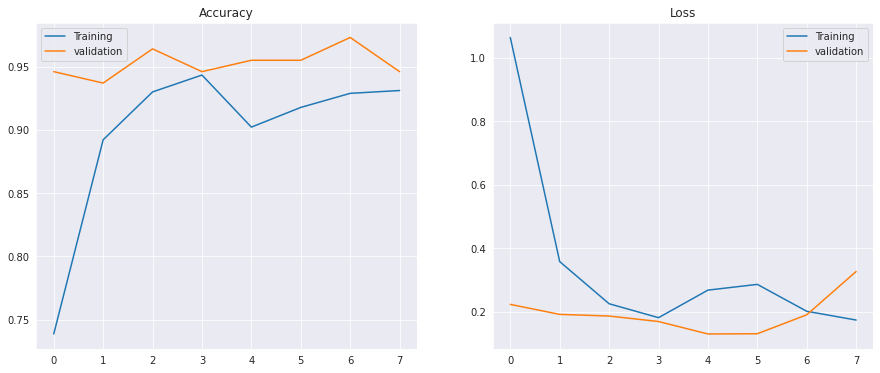

In [18]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Predictions**

In [19]:
pred = model.predict(test_ds,verbose=1)

6/6 [==============================] - 25s 499ms/step


In [20]:
pred = [np.argmax(i) for i in pred]
pred[:5]

[0, 0, 0, 0, 0]

In [21]:
y_test = test_ds.classes
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3], dtype=int32)

In [22]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.95      1.00      0.97        35
           2       1.00      1.00      1.00        22
           3       0.96      0.93      0.94        27

    accuracy                           0.97       115
   macro avg       0.98      0.97      0.97       115
weighted avg       0.97      0.97      0.97       115



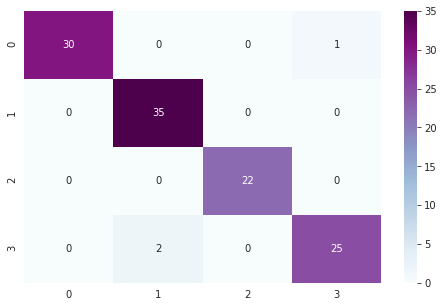

In [23]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(pred,y_test),annot=True,fmt='d',cmap = 'BuPu');

**Visuals**

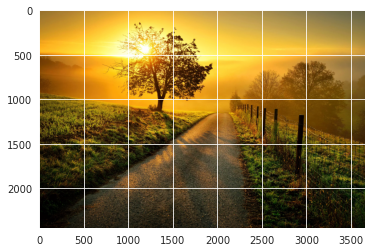

In [31]:
plt.imshow(Image.open('./Sunrise.webp'));

In [26]:
#preprocess file
def predict_img(path):
    img = image.load_img(path,target_size=(150,150))
    img_arr = image.img_to_array(img)
    img_arr_expnd  = np.expand_dims(img_arr,axis=0)
    img = keras.applications.densenet.preprocess_input(img_arr_expnd)
    
    pred = model.predict(img)
    result = classes[np.argmax(pred)]
    
    return result

In [32]:
predict_img('./Sunrise.webp')

'Dawn'